In [154]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats
from scipy.stats  import pearsonr
# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
data

<ipython-input-154-25439ef030be>:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,-0.786623
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,0.453492
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,0.453492
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,-0.786623


In [155]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()

data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore = cols2zscore.drop('residual sugar')
# create a new column for binarized (boolean) quality



In [156]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()

labels = labels[:,None] # transform to matrix

In [157]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [191]:
# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### Входной слой
        self.input = nn.Linear(11, 16)
        self.batchnorm1 = nn.BatchNorm1d(16)  # BatchNorm для первого слоя

        ### Скрытые слои
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        ### Выходной слой
        self.output = nn.Linear(32, 1)

    # Прямое распространение
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.batchnorm1(x)       # Применяем заранее инициализированный BatchNorm
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)




In [192]:
# a function that trains the model

# global parameter
numepochs = 148

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01,weight_decay=0.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchyhat  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchyhat.append(yHat)
      batchAcc.append(y)
      # loss from this batch
    s1 = torch.Tensor( batchAcc)
    s2 = torch.Tensor( batchyhat)
    trainAcc.append(pearsonr(s1.reshape(-1),s2.reshape(-1))[0]*100)

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)

    testAcc.append(pearsonr(yHat.reshape(-1),y.reshape(-1))[0]*100)

  # function output
  return trainAcc,testAcc,losses

In [193]:

# This cell takes ~15 mins

# range of batch sizes
batchsizes = 1

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,1))
accuracyResultsTest  = np.zeros((numepochs,1))
comptime             = np.zeros(batchsizes)

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(batchsizes):

  # start the clock!
  starttime = time.process_time()

  # create dataloader object
  train_loader = DataLoader(train_dataDataset,
                          batch_size=batchsizes, shuffle=True, drop_last=True)

  # create and train a model
  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  # # store data
  # accuracyResultsTrain[:,bi] = trainAcc.mean()
  # accuracyResultsTest[:,bi]  = testAcc.mean()

  # check the timer
  comptime[bi] = time.process_time() - starttime


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 16])

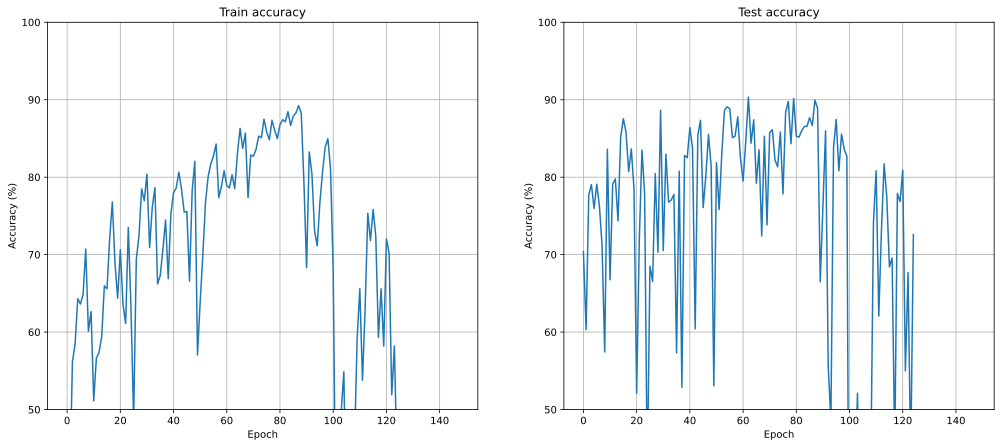

[34.596887597718926, 40.16924385198129, 56.16689620462954, 58.45954579614783, 64.30338008944668, 63.62118932734302, 64.85388727272328, 70.71442256368327, 60.100750373947356, 62.640927987828995, 51.127737552672514, 56.64297467185555, 57.386385677698684, 59.40174913774806, 65.96406795376706, 65.58214812654354, 72.14214721861786, 76.79835065976368, 68.8224960487829, 64.38177634975574, 70.62241646541754, 63.60267050551137, 61.10449201876846, 73.49452986837416, 63.214674397904204, 48.665822237739334, 69.37084280983629, 72.39199623787094, 78.4779881577572, 76.96714903180701, 80.38204184651639, 70.90750630823861, 76.11928793026681, 78.64510821922394, 66.22315740451788, 67.31175133673119, 70.64540642236734, 74.46019311844384, 66.89171581186791, 75.2734821294717, 77.97636646321612, 78.61347740198418, 80.64566172040799, 78.43730817231783, 75.4865211010602, 75.57342053620272, 66.57954835506179, 78.23382865372987, 82.04283437756746, 57.03682812358481, 63.83764451516038, 69.845864706356, 76.7302350

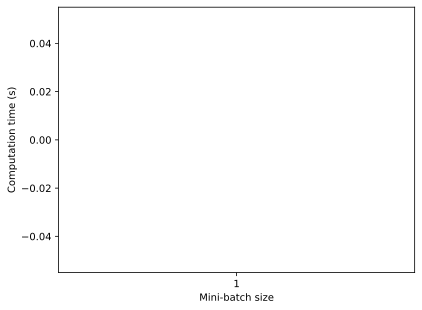

In [190]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(testAcc)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

print(trainAcc)

# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()